
# Chew Detection from Nose Accelerometer using Sliding‑Window LSTM → Probability Trace → Peak Counting

 We split the accelerometer time series into fixed windows; an **LSTM** predicts whether a **single chew** falls near the **center** of each window (binary classification). We then **reconstruct a probability trace** \(p(t)\) by overlap‑adding window probabilities, **peak‑pick** \(p(t)\), and **count** chews per bout. Thresholds are chosen on train bouts to minimize **per‑bout count MAE**, not per‑window F1.



## 0) Requirements & Configuration

In [ ]:

import warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
from typing import List, Tuple
from scipy.signal import butter, filtfilt, hilbert, find_peaks, detrend as sp_detrend, peak_prominences

warnings.filterwarnings("ignore")
plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.grid"] = True

# ---- Paths (EDIT THESE to match your machine) ----
ACCEL_PATH = r"C:\Users\eleut\OneDrive\Desktop\teraterm_11_08_2025_accelerometer.csv"
BORIS_PATH = r"C:\Users\eleut\OneDrive\Desktop\boris_video3.csv"

# ---- Video→accelerometer mapping: t_acc = VIDEO_START_ACCEL + BORIS_Time ----
VIDEO_START_ACCEL = 349.75
VIDEO_END_ACCEL   = 930.8

# ---- Known bouts (accelerometer seconds). Bout #10 is very short → skip in test plots. ----
VIDEO_BOUTS = [
    (374.8, 424.8),(428.8, 489.8),(493.8, 532.8),(539.8, 602.8),(607.8, 669.8),
    (674.8, 734.8),(738.8, 794.8),(802.8, 860.8),(866.8, 923.8),(927.8, 930.8)
]

# ---- Signal processing (conservative, narrow band around rumination rhythm) ----
F_LO, F_HI, FILT_ORDER = 0.5, 3.0, 4     # Butterworth band‑pass (zero‑phase with filtfilt)
ENV_SMOOTH_S     = 0.20                  # envelope smoothing for features (~200 ms)
ENV_SMOOTH_VIS_S = 0.03                  # envelope smoothing for plots (~30 ms, sharper)

# ---- Sliding‑window LSTM ----
WIN_SEC    = 1.4                         # window length (s)
STRIDE_SEC = 0.05                        # hop (s) → dense centers
POS_RADIUS = 0.25                        # window center is positive if within ±radius of a chew midpoint

# ---- Train/Test split by bouts (1‑based indices). Avoid #10 in test. ----
TRAIN_BOUTS = list(range(1, 8))          # 1..7
TEST_BOUTS  = [8, 9]

# ---- Probability‑trace decoding (grid to choose threshold on train MAE) ----
SMOOTH_PT_SEC   = 0.05                   # median filter width for p(t)
GRID_THR_Q      = np.linspace(0.50, 0.95, 16)  # candidate quantiles for threshold
GRID_PROM_MAD   = [0.0, 0.5, 1.0]        # prominence = k * MAD(p)
GRID_MIN_DIST_S = [0.55, 0.60, 0.65]     # min distance between p(t) peaks (s)

# ---- Plot selection (3 bouts; skip 10) ----
SELECT_BOUT_IDS = [7, 8, 9]
ZOOM_SECONDS    = 10.0



## 1) Helper functions
Small, testable utilities: time parsing, sampling‑rate estimate, filtering, smoothing, robust MAD, and bout mapping.


In [ ]:

def robust_seconds(s: pd.Series) -> pd.Series:
    """
    Convert a time column to seconds (float). Accepts numeric seconds, strings (','->'.'),
    or timestamps; if timestamps, subtract the first non‑null timestamp.
    """
    if s.dtype.kind in "if":
        return s.astype(float)
    z = s.astype(str).str.replace(",", ".", regex=False).str.strip()
    sec = pd.to_numeric(z, errors="coerce")
    if sec.notna().sum() > 0:
        return sec
    dt = pd.to_datetime(z, errors="coerce")
    return (dt - dt.dropna().iloc[0]).dt.total_seconds()

def estimate_fs(t: np.ndarray) -> float:
    """Estimate sampling rate as 1 / median(dt) (ignores non‑positive and non‑finite deltas)."""
    dt = np.diff(t); dt = dt[(dt > 0) & np.isfinite(dt)]
    return float(1.0 / np.median(dt))

def butter_bandpass_filter(x, fs, low=0.5, high=3.0, order=4):
    """
    Band‑pass Butterworth + filtfilt to avoid phase delay.
    Caps 'high' to 0.45*fs for numerical safety.
    """
    nyq = 0.5*fs
    high = min(high, 0.45*fs)
    Wn = [low/nyq, high/nyq]
    b, a = butter(order, Wn, btype="bandpass")
    return filtfilt(b, a, x)  # zero‑phase

def moving_average(x, w):
    """Centered moving average with safe edges."""
    if w <= 1: return x
    return pd.Series(x).rolling(w, center=True, min_periods=1).mean().to_numpy()

def robust_mad(x, c=1.4826):
    """Robust scale estimate: c * median(|x - median(x)|). Adds a tiny epsilon to avoid zero."""
    med = np.median(x); 
    return float(c*np.median(np.abs(x-med))+1e-12)

def which_interval(ti: float, intervals: List[Tuple[float,float]]) -> int:
    """Return the 0‑based index of the interval [s,e] that contains ti, or −1 if none."""
    for i,(s,e) in enumerate(intervals):
        if s <= ti <= e: return i
    return -1



## 2) Load accelerometer & preprocess (filter → envelope)

- **Filter**: 0.5–3 Hz **Butterworth** (zero‑phase via `filtfilt`) to keep the rumination band.  
- **Envelope**: magnitude of the **analytic signal** via **Hilbert**; then mild smoothing (for features).  
- We also compute a sharper `env_vis` for **plots** only.


In [ ]:

acc = pd.read_csv(ACCEL_PATH)
acc = acc.rename(columns={c: c.strip() for c in acc.columns})

# Build the absolute time vector (seconds)
if "time_s" in acc.columns and not acc["time_s"].isna().all():
    t = robust_seconds(acc["time_s"]).to_numpy()
elif "timestamp" in acc.columns:
    ts = pd.to_datetime(acc["timestamp"], errors="coerce")
    t = (ts - ts.dropna().iloc[0]).dt.total_seconds().to_numpy()
else:
    raise ValueError("Accelerometer CSV must contain 'time_s' or 'timestamp'.")

# Use X axis (you can extend to multi‑axis later)
x  = pd.to_numeric(acc["x"], errors="coerce").ffill().bfill().to_numpy()
fs = estimate_fs(t)

# Detrend → band‑pass → envelope
x_dt = sp_detrend(x)
x_f  = butter_bandpass_filter(x_dt, fs, F_LO, F_HI, FILT_ORDER)
env  = np.abs(hilbert(x_f))
env  = moving_average(env, max(1,int(round(ENV_SMOOTH_S*fs))))

# Restrict to video interval on accelerometer time
m_v   = (t >= VIDEO_START_ACCEL) & (t <= VIDEO_END_ACCEL)
t_v   = t[m_v]
x_f_v = x_f[m_v]
env_v = env[m_v]

# Sharper envelope for plotting (not used for features)
env_vis = moving_average(env_v, max(1,int(round(ENV_SMOOTH_VIS_S*fs))))
env_vis = env_vis / (np.percentile(env_vis, 95)+1e-12)

print(f"[ACCEL] fs={fs:.3f} Hz | samples={len(x)} | video dur={VIDEO_END_ACCEL-VIDEO_START_ACCEL:.3f}s")


[ACCEL] fs=76.923 Hz | samples=120066 | video dur=581.050s



## 3) BORIS **S/E** → chew midpoints (labels) + S/E for plotting

We read rows labeled **S**/**E** and build **chew midpoints = 0.5·(S+E)** (accelerometer seconds).  
We also keep **S** (yellow) and **E** (black) to draw vertical lines in the plots.


In [ ]:

def pick_boris_time_col(df: pd.DataFrame) -> str:
    """Heuristic: prefer 'Time'; fallback to 'time_s' or 't'."""
    for c in df.columns:
        if c.strip().lower()=="time": return c
    for name in ("time_s","t"):
        for c in df.columns:
            if c.strip().lower()==name: return c
    raise ValueError("BORIS: missing time column ('Time'/'time_s'/'t').")

def parse_boris_SE(boris_csv: str, video_start_accel: float):
    """
    Return (chew_midpoints_acc, S_acc, E_acc), all in accelerometer seconds,
    clipped to [VIDEO_START_ACCEL, VIDEO_END_ACCEL].
    """
    dfb = pd.read_csv(boris_csv)
    tc = pick_boris_time_col(dfb)
    beh_col = next((c for c in dfb.columns if c.strip().lower() in ("behavior","behaviour")), None)
    if beh_col is None: return np.array([]), np.array([]), np.array([])

    d = dfb[dfb[beh_col].astype(str).str.strip().str.lower().isin(["s","e"])].copy()
    d["_ev"] = d[beh_col].astype(str).str.strip().str.upper()
    d["_t"]  = pd.to_numeric(d[tc], errors="coerce").astype(float)
    d = d.dropna(subset=["_ev","_t"]).sort_values("_t")

    # Map BORIS time → accelerometer time
    S = d.loc[d["_ev"]=="S","_t"].to_numpy() + float(video_start_accel)
    E = d.loc[d["_ev"]=="E","_t"].to_numpy() + float(video_start_accel)

    # Pair S with the next E and take midpoint; ignore unmatched events
    mids = []; j = 0
    for s in S:
        while j < len(E) and E[j] <= s: j += 1
        if j < len(E):
            mids.append(0.5*(s+E[j]))
            j += 1

    chew_t_acc = np.array(mids, float)
    # Clip to video range
    inV = (chew_t_acc>=VIDEO_START_ACCEL)&(chew_t_acc<=VIDEO_END_ACCEL)
    chew_t_acc = chew_t_acc[inV]
    S = S[(S>=VIDEO_START_ACCEL)&(S<=VIDEO_END_ACCEL)]
    E = E[(E>=VIDEO_START_ACCEL)&(E<=VIDEO_END_ACCEL)]
    return chew_t_acc, S, E

chew_t, S_acc, E_acc = parse_boris_SE(BORIS_PATH, VIDEO_START_ACCEL)

# Convenience for plotting in "video seconds" (0 at VIDEO_START_ACCEL)
t_vid = t_v - VIDEO_START_ACCEL
S_vid = S_acc - VIDEO_START_ACCEL
E_vid = E_acc - VIDEO_START_ACCEL



## 4) Sliding windows + **center‑positive** labels + train/test split

- Window center times are the **anchors**; a window is **positive** if a chew midpoint lies within `±POS_RADIUS`.  
- We split **by bouts**: train on bouts 1–7, test on 8–9 (skip 10).  
- We optionally **downsample negatives** in the train set to balance classes.


In [ ]:

def build_windows(t, x_f, env, fs, win_sec=1.4, stride_sec=0.05, add_diff=True):
    """
    Return:
      Xseq: [n_windows, T, C] where C = 2 or 3 (x_f, env, d(env))
      cidx: center sample indices
      ct:   center times (seconds, accelerometer axis)
    """
    T   = int(round(win_sec*fs))
    hop = max(1, int(round(stride_sec*fs)))
    half = T//2
    env_diff = np.diff(env, prepend=env[0]) if add_diff else None

    centers_idx, centers_t, Xseq = [], [], []
    for c in range(half, len(env)-half, hop):
        i0, i1 = c-half, c+half
        xf = x_f[i0:i1]; ev = env[i0:i1]
        X  = np.stack([xf, ev, env_diff[i0:i1]], axis=1) if add_diff else np.stack([xf, ev], axis=1)
        centers_idx.append(c); centers_t.append(t[c]); Xseq.append(X.astype(np.float32))
    return np.array(Xseq), np.array(centers_idx, int), np.array(centers_t, float)

def label_center_positive(centers_t, events_t, radius=0.25):
    """
    Label each center time as 1 if within ±radius of the nearest event time, else 0.
    """
    y = np.zeros(len(centers_t), dtype=int)
    if len(events_t)==0: return y
    ev = np.sort(events_t); j=0
    for i,tc in enumerate(centers_t):
        while j+1<len(ev) and ev[j+1] < tc - radius:
            j += 1
        d = abs(tc-ev[j])
        if j+1<len(ev): d = min(d, abs(tc-ev[j+1]))
        if d <= radius: y[i] = 1
    return y

Xseq_all, cidx_all, ct_all = build_windows(t_v, x_f_v, env_v, fs, WIN_SEC, STRIDE_SEC, add_diff=True)
ywin_all = label_center_positive(ct_all, chew_t, POS_RADIUS)

# Map each center time to a bout index (−1 if outside all bouts)
win_groups  = np.array([which_interval(tc, VIDEO_BOUTS) for tc in ct_all], dtype=int)
win_groups1 = win_groups + 1  # make them 1‑based for easy comparison

# Train/Test masks by bouts; optionally include out‑of‑bout windows as extra negatives for train
is_train = np.isin(win_groups1, TRAIN_BOUTS) | (win_groups == -1)
is_test  = np.isin(win_groups1, TEST_BOUTS)

# Class balancing on train: keep up to 3× negatives of the positives
rng = np.random.default_rng(123)
neg = np.where((ywin_all==0)&is_train)[0]
pos = np.where((ywin_all==1)&is_train)[0]
keep_neg = rng.choice(neg, size=min(len(neg), 3*max(1,len(pos))), replace=False) if len(neg) else np.array([],int)
keep_train = np.sort(np.concatenate([pos, keep_neg]))

X_tr, y_tr, ct_tr = Xseq_all[keep_train], ywin_all[keep_train], ct_all[keep_train]
X_te, y_te, ct_te = Xseq_all[is_test],     ywin_all[is_test],     ct_all[is_test]

print(f"[windows] total={len(Xseq_all)} | positives={ywin_all.sum()} | train={len(X_tr)} | test={len(X_te)}")


[windows] total=19065 | positives=9887 | train=15233 | test=3746



## 5) LSTM: training & per‑window probabilities

- Small 1‑layer LSTM (48 units) + Dropout.  
- **Class weights** mitigate imbalance.  
- Keep a copy of feature **mean/std** for test‑time normalization.


In [ ]:

try:
    import tensorflow as tf
    from tensorflow.keras import layers, models, callbacks, optimizers
except Exception as e:
    raise RuntimeError("TensorFlow not found. Install with `pip install tensorflow`.") from e

def train_lstm(seq_tr, y_tr, seq_va, y_va, epochs=30, batch_size=128):
    """
    Normalize per‑channel (mean/std) on TRAIN only; store stats on the model object.
    Early stopping on val loss to reduce overfitting.
    """
    mu  = np.nanmean(seq_tr, axis=(0,1), keepdims=True)
    sig = np.nanstd (seq_tr, axis=(0,1), keepdims=True) + 1e-8
    tr_n = (seq_tr - mu)/sig
    va_n = (seq_va - mu)/sig

    T, C = seq_tr.shape[1], seq_tr.shape[2]
    inp = layers.Input(shape=(T, C))
    x   = layers.LSTM(48)(inp)
    x   = layers.Dropout(0.30)(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inp, out)
    model.compile(optimizer=optimizers.Adam(1e-3),
                  loss="binary_crossentropy",
                  metrics=["AUC", "Precision", "Recall"])

    pos = int((y_tr==1).sum()); neg = int((y_tr==0).sum())
    w_pos = 0.5*(pos+neg)/max(1,pos); w_neg = 0.5*(pos+neg)/max(1,neg)

    es = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    model.fit(tr_n, y_tr, validation_data=(va_n, y_va),
              epochs=epochs, batch_size=batch_size,
              class_weight={0:float(w_neg), 1:float(w_pos)},
              verbose=2, callbacks=[es])
    model._mu, model._sig = mu, sig
    return model

# Simple train/val split at the tail of the training set
n = len(y_tr); n_va = max(1, int(0.15*n))
X_va, y_va = X_tr[-n_va:], y_tr[-n_va:]
X_tr2, y_tr2 = (X_tr[:-n_va] if n_va < n else X_tr), (y_tr[:-n_va] if n_va < n else y_tr)

win_model = train_lstm(X_tr2, y_tr2, X_va, y_va, epochs=30, batch_size=128)

def predict_lstm(model, seq):
    """Apply the stored normalization and return probabilities for each window."""
    return model.predict((seq - model._mu)/model._sig, verbose=0).ravel()

p_tr_win = predict_lstm(win_model, X_tr)
p_te_win = predict_lstm(win_model, X_te)


Epoch 1/30
102/102 - 20s - 200ms/step - AUC: 0.8241 - Precision: 0.7627 - Recall: 0.7390 - loss: 0.5171 - val_AUC: 0.9239 - val_Precision: 0.8639 - val_Recall: 0.8820 - val_loss: 0.3370
Epoch 2/30
102/102 - 19s - 184ms/step - AUC: 0.8631 - Precision: 0.8213 - Recall: 0.8066 - loss: 0.4528 - val_AUC: 0.9334 - val_Precision: 0.8838 - val_Recall: 0.8754 - val_loss: 0.3397
Epoch 3/30
102/102 - 12s - 117ms/step - AUC: 0.8657 - Precision: 0.8212 - Recall: 0.8065 - loss: 0.4509 - val_AUC: 0.9465 - val_Precision: 0.8775 - val_Recall: 0.9068 - val_loss: 0.3113
Epoch 4/30
102/102 - 12s - 116ms/step - AUC: 0.8709 - Precision: 0.8274 - Recall: 0.8015 - loss: 0.4437 - val_AUC: 0.9337 - val_Precision: 0.8445 - val_Recall: 0.9096 - val_loss: 0.3392
Epoch 5/30
102/102 - 8s - 81ms/step - AUC: 0.8725 - Precision: 0.8293 - Recall: 0.8027 - loss: 0.4403 - val_AUC: 0.9334 - val_Precision: 0.8912 - val_Recall: 0.8725 - val_loss: 0.3207
Epoch 6/30
102/102 - 8s - 82ms/step - AUC: 0.8796 - Precision: 0.8349 - 


## 6) Probability trace **p(t)** (overlap‑add) + smoothing

We map per‑window probabilities to the dense time axis using a short **Hann kernel** centered at each window center (overlap‑add).  
A small **median filter** makes \(p(t)\) more robust to spikes.


In [ ]:

def build_prob_trace_ola(p_win, center_times, t_axis, fs, kernel_sec=0.10):
    """
    Overlap‑add a small Hann kernel (normalized) at each window center, scaled by the window probability.
    Returns p(t) sampled on t_axis.
    """
    L = max(3, int(round(kernel_sec*fs))|1)
    k = np.hanning(L); k = k/(k.sum()+1e-12)
    half = L//2
    p = np.zeros(len(t_axis), float)
    # Map each center time to nearest sample index on t_axis
    idx_cent = np.array([np.argmin(np.abs(t_axis-ti)) for ti in center_times], int)
    for pw, ci in zip(p_win, idx_cent):
        i0 = max(0, ci-half); i1 = min(len(t_axis), ci+half+1)
        k0 = half - (ci - i0); k1 = k0 + (i1 - i0)
        p[i0:i1] += pw * k[k0:k1]
    return p

def median_filter_1d(x, w):
    """Naive 1‑D median filter with odd window length w (in samples)."""
    if w<=1: return x.copy()
    out = np.empty_like(x); h = w//2
    for i in range(len(x)):
        i0 = max(0, i-h); i1 = min(len(x), i+h+1)
        out[i] = np.median(x[i0:i1])
    return out

# Train/test p(t) (used for threshold selection and evaluation)
p_tr_t = build_prob_trace_ola(p_tr_win, ct_tr, t_v, fs)
p_te_t = build_prob_trace_ola(p_te_win, ct_te, t_v, fs)
sm_w   = max(3, int(round(SMOOTH_PT_SEC*fs)))
p_tr_s = median_filter_1d(p_tr_t, sm_w)
p_te_s = median_filter_1d(p_te_t, sm_w)

# p(t) over the WHOLE video (for plotting everywhere, including train bouts)
p_all_win = win_model.predict((Xseq_all - win_model._mu)/win_model._sig, verbose=0).ravel()
p_all_t   = build_prob_trace_ola(p_all_win, ct_all, t_v, fs, kernel_sec=0.10)
p_all_s   = median_filter_1d(p_all_t, max(3, int(round(0.04*fs))))



## 7) Threshold selection (on train) + per‑bout counting

We choose (threshold, prominence, min‑distance) to **minimize MAE** of **per‑bout** counts on **train** bouts.  
This is consistent with the **primary objective**: matching per‑bout counts, not per‑window F1.


In [ ]:

def truth_counts_from_midpoints(chew_times_acc, bouts_sel):
    """Count how many chew midpoints fall inside each bout interval."""
    rows=[]
    for i,(s,e) in enumerate(bouts_sel):
        rows.append({"bout":i+1, "true_count":int(np.sum((chew_times_acc>=s)&(chew_times_acc<=e)))})
    return pd.DataFrame(rows)

def count_from_ptrace(p_trace, t_vec, bouts_sel, fs, thr, prom_mad=0.0, min_dist_sec=0.60, return_times=False):
    """
    Peak‑pick p(t) with:
      - height >= thr
      - distance >= min_dist_sec (in samples)
      - optional prominence >= prom_mad * MAD(p)
    Return per‑bout predicted counts and (optionally) the picked peak indices and times.
    """
    dist = max(1, int(round(min_dist_sec*fs)))
    prom = float(prom_mad)*robust_mad(p_trace)
    idx,_ = find_peaks(p_trace, height=thr, distance=dist, prominence=(prom if prom>0 else None))
    tt = t_vec[idx]
    rows=[]
    for i,(s,e) in enumerate(bouts_sel):
        rows.append({"bout":i+1, "pred_count":int(np.sum((tt>=s)&(tt<=e)))})
    if return_times:
        return pd.DataFrame(rows), idx, tt
    return pd.DataFrame(rows), idx

train_bouts = [b for i,b in enumerate(VIDEO_BOUTS, start=1) if i in TRAIN_BOUTS]
test_bouts  = [b for i,b in enumerate(VIDEO_BOUTS, start=1) if i in TEST_BOUTS]
truth_train = truth_counts_from_midpoints(chew_t, train_bouts)
truth_test  = truth_counts_from_midpoints(chew_t, test_bouts)

# Grid over thresholds (quantiles of p_tr_s), prominence multipliers, and min distances
valid = p_tr_s[p_tr_s>0]
GRID_THR = list(np.quantile(valid, GRID_THR_Q)) if len(valid) else list(np.linspace(0.05,0.6,16))

best = {"mae":1e9}
for thr in GRID_THR:
    for pm in GRID_PROM_MAD:
        for md in GRID_MIN_DIST_S:
            dfp,_ = count_from_ptrace(p_tr_s, t_v, train_bouts, fs, thr, pm, md)
            cmp = pd.concat([truth_train["true_count"], dfp["pred_count"]], axis=1).to_numpy()
            mae = float(np.mean(np.abs(cmp[:,0]-cmp[:,1])))
            if mae < best["mae"]:
                best = {"thr":float(thr),"prom_mad":float(pm),"min_dist":float(md),"mae":mae}

print("[Grid best]", best)

# Final predictions on train/test (for bar plots)
df_pred_tr, idx_pk_tr = count_from_ptrace(p_tr_s, t_v, train_bouts, fs, best["thr"], best["prom_mad"], best["min_dist"])
df_pred_te, idx_pk_te = count_from_ptrace(p_te_s, t_v,  test_bouts,  fs, best["thr"], best["prom_mad"], best["min_dist"])


[Grid best] {'thr': 0.18941447481210297, 'prom_mad': 1.0, 'min_dist': 0.65, 'mae': 0.42857142857142855}



## 8) Plots — Envelope (green), p(t) (red), BORIS S (yellow), E (black), predicted chews (×)

We first compute **predicted chews on p(t) over the whole video** (for plotting, regardless of split).  
Then for **3 bouts** (avoid #10) we draw **full‑bout** and **10‑s zoom** panels.


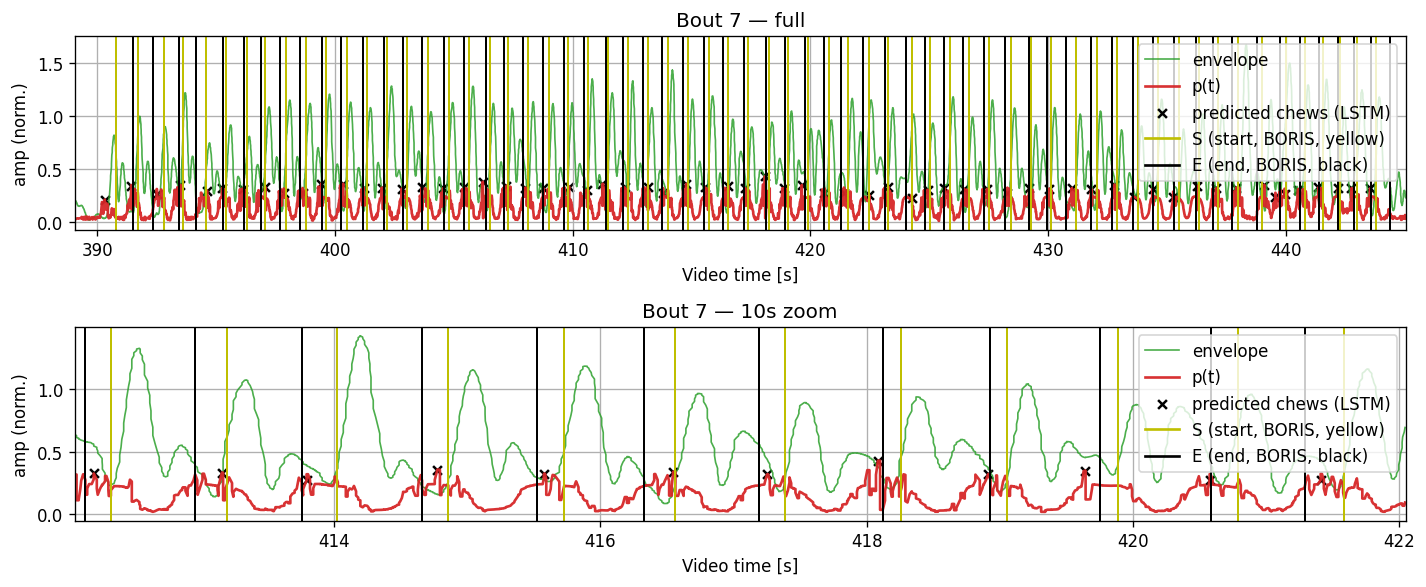

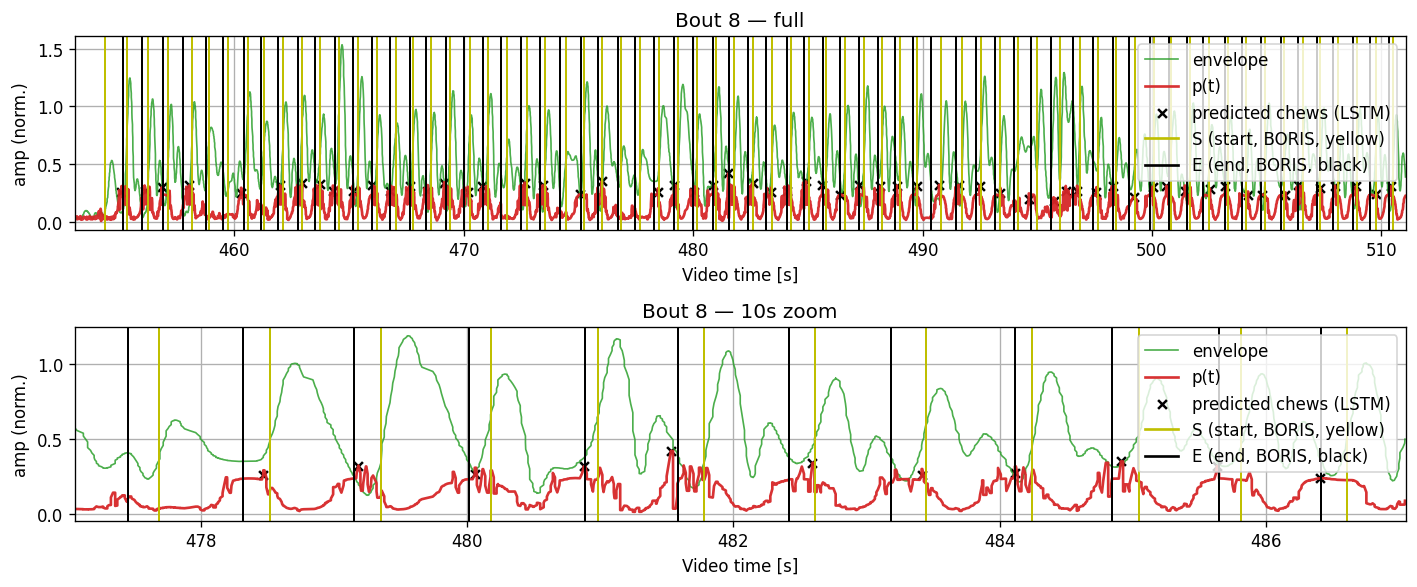

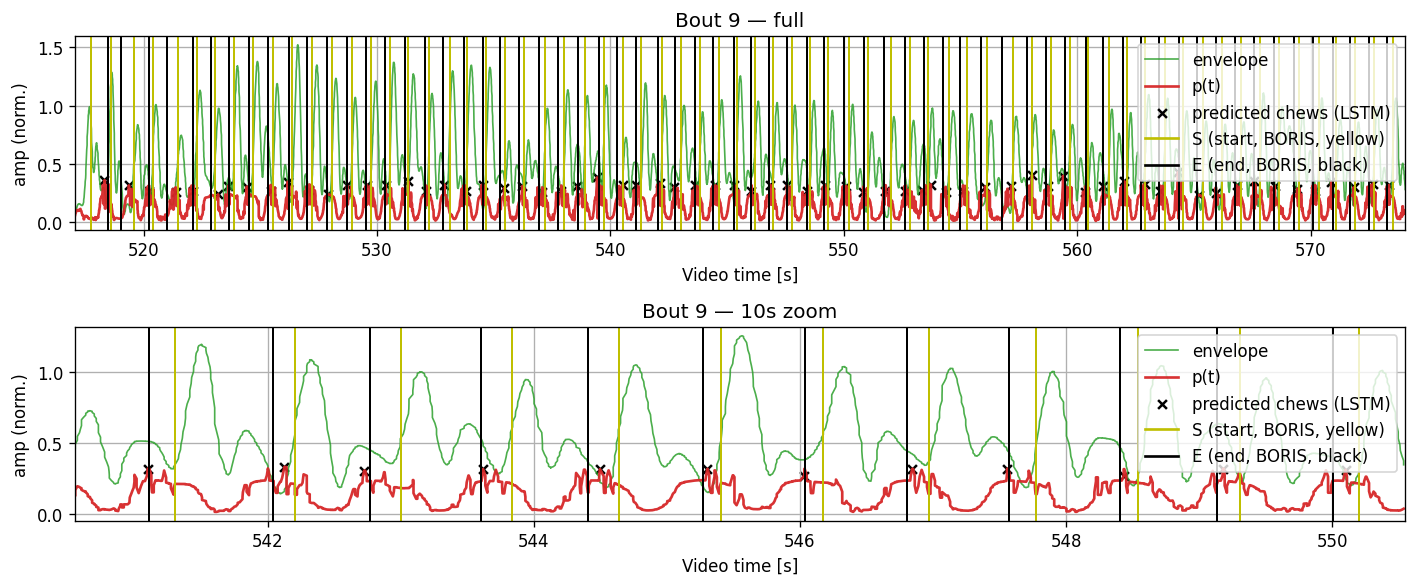

In [ ]:

# Re‑use peak picking on p_all_s to show predicted chews (×) everywhere
# (For counting we used p_tr_s/p_te_s; here we just want visualization on full video.)
try:
    THR      = float(best["thr"]); 
    PROM_MAD = float(best["prom_mad"]); 
    MIN_DIST = float(best["min_dist"])
except Exception:
    pos_vals = p_all_s[p_all_s>0]
    THR      = float(np.quantile(pos_vals, 0.80)) if len(pos_vals) else 0.2
    PROM_MAD = 0.5
    MIN_DIST = 0.60

_, idx_pk_all, tt_pk_all = count_from_ptrace(
    p_all_s, t_v, VIDEO_BOUTS, fs,
    thr=THR, prom_mad=PROM_MAD, min_dist_sec=MIN_DIST, return_times=True
)
pk_vid = tt_pk_all - VIDEO_START_ACCEL  # convert to video seconds for plotting

from matplotlib.lines import Line2D

def _clip(center, w, T):
    a = max(0.0, center - w/2); b = min(T, center + w/2)
    if b - a < 1e-6: b = a + 1e-3
    return a, b

def _plot_panel(ax, t0, t1, title=None):
    """
    Draw envelope (green), p(t) (red), predicted chews (× black), and BORIS S/E (yellow/black).
    """
    t_vid_local = t_v - VIDEO_START_ACCEL
    m = (t_vid_local>=t0)&(t_vid_local<=t1)
    ax.plot(t_vid_local[m], env_vis[m], color="tab:green", lw=1.0, alpha=0.85, label="envelope")
    ax.plot(t_vid_local[m], p_all_s[m], color="tab:red",   lw=1.6, alpha=0.95, label="p(t)")
    # Predicted chews as × markers at p(t) peak times
    pm = (pk_vid>=t0)&(pk_vid<=t1)
    if pm.any():
        idx_near = np.searchsorted(t_vid_local, pk_vid[pm]).clip(0, len(t_vid_local)-1)
        ax.scatter(pk_vid[pm], p_all_s[idx_near], s=28, marker="x", color="k", label="predicted chews (LSTM)")
    # BORIS S/E vertical lines
    s_vid = S_acc - VIDEO_START_ACCEL
    e_vid = E_acc - VIDEO_START_ACCEL
    for s in s_vid[(s_vid>=t0)&(s_vid<=t1)]: ax.axvline(s, color='y', lw=1.2)
    for e in e_vid[(e_vid>=t0)&(e_vid<=t1)]: ax.axvline(e, color='k', lw=1.2)
    # Legend with explicit S/E items
    handles, labels = ax.get_legend_handles_labels()
    handles += [Line2D([0],[0], color='y', lw=1.6), Line2D([0],[0], color='k', lw=1.6)]
    labels  += ["S (start, BORIS, yellow)", "E (end, BORIS, black)"]
    ax.legend(handles, labels, loc="upper right")
    ax.set_xlim(t0,t1); ax.set_xlabel("Video time [s]"); ax.set_ylabel("amp (norm.)")
    if title: ax.set_title(title)

# Plot three bouts (skip #10 because too short)
t_vid_all = t_v - VIDEO_START_ACCEL
video_dur = float(VIDEO_END_ACCEL - VIDEO_START_ACCEL)
for bid in [b for b in SELECT_BOUT_IDS if b != 10 and 1 <= b <= len(VIDEO_BOUTS)]:
    bs, be = VIDEO_BOUTS[bid-1]
    bs_v, be_v = bs - VIDEO_START_ACCEL, be - VIDEO_START_ACCEL

    fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=False)
    _plot_panel(axes[0], bs_v, be_v, title=f"Bout {bid} — full")
    c = 0.5*(bs_v+be_v); z0, z1 = _clip(c, ZOOM_SECONDS, video_dur)
    _plot_panel(axes[1], z0, z1, title=f"Bout {bid} — {ZOOM_SECONDS:.0f}s zoom")
    plt.tight_layout(); plt.show()



## 9) Bar charts — **BORIS vs LSTM** per‑bout counts (with numbers)

Two charts: one for **train** bouts and one for **test** bouts. We draw numeric labels above each bar.


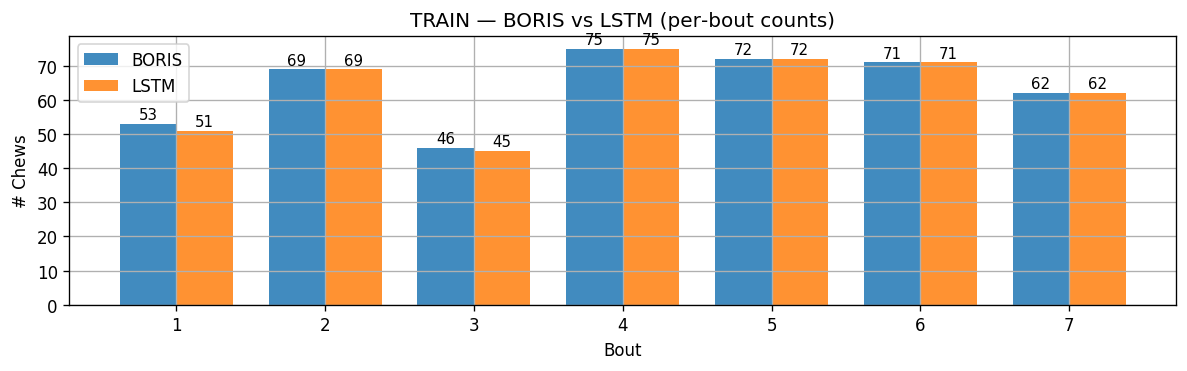

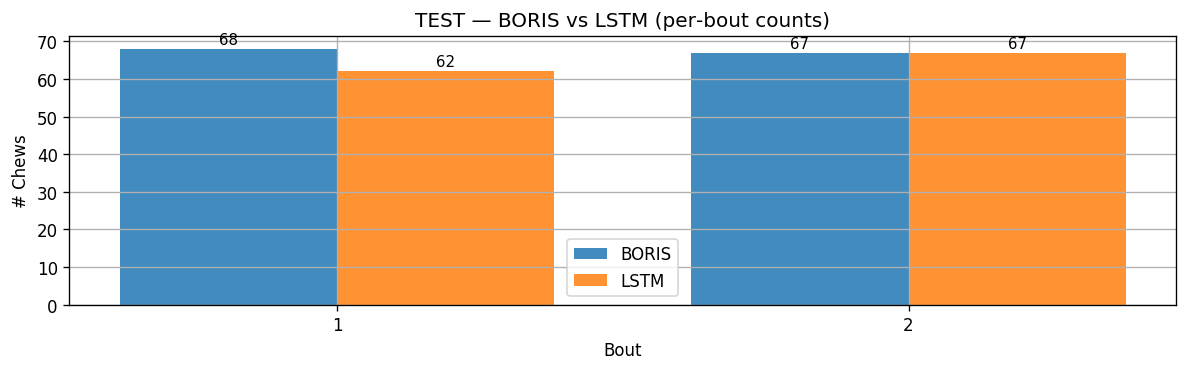

In [ ]:

def truth_counts_from_boris_midpoints(s_acc, e_acc, bouts_sel):
    """Use paired S/E → midpoints as ground‑truth chews for counting by bout."""
    n = int(min(len(s_acc), len(e_acc)))
    if n == 0:
        return pd.DataFrame([{"bout":i+1, "true_count":0} for i in range(len(bouts_sel))])
    mids = 0.5*(s_acc[:n] + e_acc[:n])
    rows = []
    for i,(s,e) in enumerate(bouts_sel):
        rows.append({"bout":i+1, "true_count": int(np.sum((mids>=s)&(mids<=e)))})
    return pd.DataFrame(rows)

def bar_counts_with_labels(df_truth, df_pred, title):
    """Side‑by‑side bars with count labels above each bar."""
    df = pd.merge(df_truth, df_pred, on="bout", how="left").fillna(0)
    x = np.arange(len(df)); w = 0.38
    fig, ax = plt.subplots(figsize=(10,3.2))
    bars1 = ax.bar(x - w/2, df["true_count"].astype(int), width=w, label="BORIS", alpha=0.85)
    bars2 = ax.bar(x + w/2, df["pred_count"].astype(int), width=w, label="LSTM",  alpha=0.85)
    for b in bars1:
        ax.text(b.get_x()+b.get_width()/2, b.get_height()+0.5, f"{int(b.get_height())}", ha="center", va="bottom", fontsize=9)
    for b in bars2:
        ax.text(b.get_x()+b.get_width()/2, b.get_height()+0.5, f"{int(b.get_height())}", ha="center", va="bottom", fontsize=9)
    ax.set_xticks(x); ax.set_xticklabels([str(b) for b in df["bout"].tolist()])
    ax.set_xlabel("Bout"); ax.set_ylabel("# Chews"); ax.set_title(title)
    ax.legend(); plt.tight_layout(); plt.show()

# Build truth from S/E (accelerometer seconds)
train_bouts = [b for i,b in enumerate(VIDEO_BOUTS, start=1) if i in TRAIN_BOUTS]
test_bouts  = [b for i,b in enumerate(VIDEO_BOUTS, start=1) if i in TEST_BOUTS]
truth_train_bars = truth_counts_from_boris_midpoints(S_acc, E_acc, train_bouts)
truth_test_bars  = truth_counts_from_boris_midpoints(S_acc, E_acc, test_bouts)

bar_counts_with_labels(truth_train_bars, df_pred_tr, "TRAIN — BORIS vs LSTM (per‑bout counts)")
bar_counts_with_labels(truth_test_bars,  df_pred_te, "TEST — BORIS vs LSTM (per‑bout counts)")



## 11) References (APIs/tools used)
- SciPy `butter` (Butterworth) & `filtfilt` (zero‑phase).  
- SciPy `hilbert` (analytic signal → envelope).  
- SciPy `find_peaks` & `peak_prominences` (peak picking).  
- Keras / TensorFlow **LSTM** layer.

